In [10]:
from elasticsearch import Elasticsearch
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np
from sklearn.linear_model import LinearRegression

In [11]:
es = Elasticsearch(
        'https://127.0.0.1:9200',
        basic_auth=('elastic', 'gHcmDFVtcTaCkB4QPVHSYkEe7bTbYd!x'),
        verify_certs=False
    )

/home/kejing/miniconda3_py38/lib/python3.8/site-packages/elasticsearch/_sync/client/__init__.py:399: SecurityWarning: Connecting to 'https://127.0.0.1:9200' using TLS with verify_certs=False is insecure
  _transport = transport_class(


In [12]:
# def secret(key: str) -> str:
#     """Read secret from k8s secret volume"""
#     with open(f"/secrets/default/secrets/{key}", "r", encoding="utf-8") as f:
#         return f.read()


# host = secret("ES_URL")
# basic_auth = (secret("ES_USERNAME"), secret("ES_PASSWORD"))
# es = Elasticsearch(host, basic_auth=basic_auth, verify_certs=False)

In [13]:
# # 定义查询语句
# query = {
#     "query": {
#         "match_all": {}
#     }
# }

# # 执行查询
# weather_index_name = 'bom_melbourne_weather_past'
# response = es.search(index=weather_index_name, body=query, size=500)  # size 参数设置为较大值以获取更多数据
# weather_hits = response['hits']['hits']
# weather_data = []

# for hit in weather_hits:
#     source = hit['_source']
#     weather_data.append({
#         'Date': source['Date'],
#         'Rainfall (mm)': source['Rainfall (mm)']
#     })

# weather_df = pd.DataFrame(weather_data)
# weather_df['Date'] = pd.to_datetime(weather_df['Date'])
# weather_df = weather_df.sort_values('Date')
# weather_df.set_index('Date', inplace=True)

# weather_df

# # # 转换 Date 列为日期格式
# # df['Date'] = pd.to_datetime(df['Date'])

# # # 按日期排序
# # df = df.sort_values('Date')

# # # 设置 Date 列为索引
# # df.set_index('Date', inplace=True)

# # # 显示前几行数据
# # print(df.head())

# # # 数据分析和可视化示例
# # plt.figure(figsize=(12, 6))
# # plt.plot(df.index, df['Rainfall (mm)'], marker='o')
# # plt.title('Rainfall Over Time')
# # plt.xlabel('Date')
# # plt.ylabel('Rainfall (mm)')
# # plt.grid(True)
# # plt.show()


In [14]:
def get_rainfall(date):
    url = f"http://localhost:9090/bom-past-rainfall/rainfall/{date}"
    headers = {"X-Fission-Params-Date": date}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.json().get('rainfall_amount', 0)
    else:
        return "error"

In [15]:
def get_accident_count(date):
    url = f"http://localhost:9090/traffic-accident/accident-count/{date}"
    headers = {"X-Fission-Params-Date": date}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.json().get('center_accidents', 0)
    else:
        return "error"

In [16]:
# create a dataframe for storing the accident data and rainfall data
accident_data = []
rainfall_data = []
# set date range from 2023-04-01 to 2023-09-30
date_range = pd.date_range(start='2023-04-01', end='2023-09-30')

for date in date_range:
    date_str = date.strftime('%Y-%m-%d')
    accident_count = get_accident_count(date_str)
    rainfall = get_rainfall(date_str)
    accident_data.append({
        'Date': date,
        'Accident Count': accident_count
    })
    rainfall_data.append({
        'Date': date,
        'Rainfall (mm)': rainfall
    })

accident_df = pd.DataFrame(accident_data)
rainfall_df = pd.DataFrame(rainfall_data)

# set date as the index
accident_df.set_index('Date', inplace=True)
rainfall_df.set_index('Date', inplace=True)

print(accident_df.head())
print(rainfall_df.head())

            Accident Count
Date                      
2023-04-01              13
2023-04-02              12
2023-04-03              12
2023-04-04              12
2023-04-05               9
            Rainfall (mm)
Date                     
2023-04-01            4.6
2023-04-02            0.2
2023-04-03            0.0
2023-04-04            0.0
2023-04-05            0.0


            Rainfall (mm)  Accident Count
Date                                     
2023-04-01            4.6              13
2023-04-02            0.2              12
2023-04-03            0.0              12
2023-04-04            0.0              12
2023-04-05            0.0               9


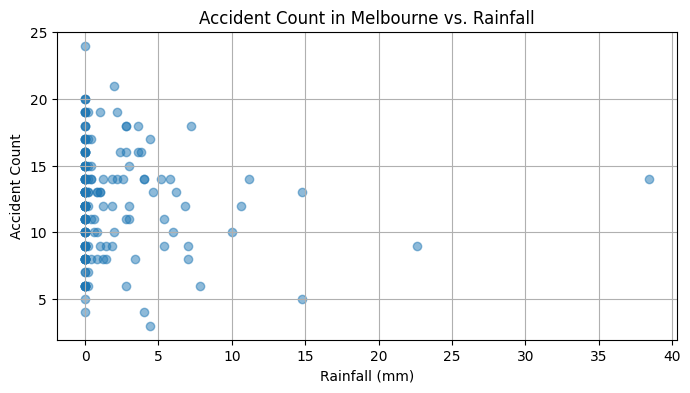

In [22]:
# merge weather rainfall data and accident data
combined_df = pd.merge(rainfall_df, accident_df, left_index=True, right_index=True)
print(combined_df.head())

# scatter plot 
plt.figure(figsize=(8, 4))
plt.scatter(combined_df['Rainfall (mm)'], combined_df['Accident Count'], alpha=0.5)

# draw a best fit line
# X = combined_df['Rainfall (mm)'].values.reshape(-1, 1)
# y = combined_df['Accident Count'].values

# model = LinearRegression()
# model.fit(X, y)
# best_fit_line = model.predict(X)
# plt.plot(combined_df['Rainfall (mm)'], best_fit_line, color='red', label='Best fit line')

plt.title('Accident Count in Melbourne vs. Rainfall')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Accident Count')
plt.grid(True)
plt.show()